# image-classifier

In [2]:
import os
import tensorflow as tf
import abcli
from abcli import string
from abcli.plugins import gpu
import image_classifier

from helper_functions import plot_loss_curves, compare_histories, view_random_image

from abcli import logging
import logging

logger = logging.getLogger(__name__)

logger.info(f"using {abcli.fullname()}, {image_classifier.name}-{image_classifier.version}")
logger.info(f"{os.environ.get('abcli_object_name')} - built on {string.pretty_date()}")

gpu.validate();

using abcli-1.1.477-main, image_classifier-1.1.41
2022-07-06-20-12-58-57931 - built on 06 July 2022, 20:36:23
TensorFlow: 2.6.0
0 GPU(s) available: [].


In [3]:
validation = True

input_object = os.path.join(os.getenv("abcli_object_root"),"ic_input_object_v2")
output_object = os.path.join(os.getenv("abcli_object_root"),"ic_output_object_v1")

if validation:
    initial_epochs = 1
    fine_tune_epochs = 1
else:
    initial_epochs = 5
    fine_tune_epochs = 5

## Create image datasets from directories

In [4]:
train_30_percent = tf.keras.preprocessing.image_dataset_from_directory(
  os.path.join(input_object,'train_30'),
  image_size = (224, 224),
  label_mode = 'categorical',
  seed = 42
)

train_data = tf.keras.preprocessing.image_dataset_from_directory(
  os.path.join(input_object,'train'),
  image_size = (224, 224),
  label_mode = 'categorical',
  seed = 42
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
  os.path.join(input_object,'test'),
  image_size = (224, 224),
  label_mode = 'categorical',
  seed = 42
)

validation_data = tf.keras.preprocessing.image_dataset_from_directory(
  os.path.join(input_object,'validation'),
  image_size = (224, 224),
  label_mode = 'categorical',
  seed = 42
)

Found 4500 files belonging to 15 classes.
Found 15000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.


## Create data augmentation layer

In [5]:
from image_classifier import augmentation

data_augmentation = augmentation.create_layer()

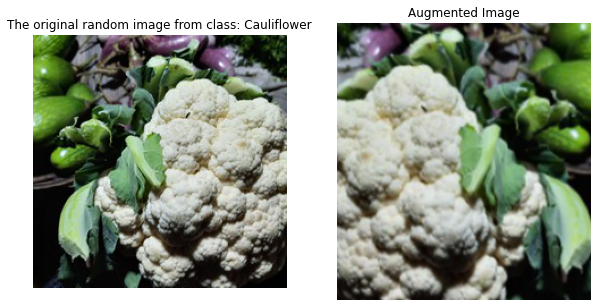

In [7]:
view_random_image(input_object, train_data, data_augmentation)

## Creating checkpoint callback


In [ ]:
checkpoint_path = os.path.join(output_object,'checkpoint_30_percent/checkpoint.ckpt')

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights=True,
    save_best_only=True,
    save_freq='epoch',
    verbose=1
)

# Create Feature Extraction models



## Feature Extraction base model

In [ ]:
from numpy import e
from tensorflow.keras import layers


# Setup input shape and base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name = 'input_layer')

x = data_augmentation(inputs)

x = base_model(x, training=False)

# Extract features from model
x = layers.GlobalAveragePooling2D (name='global_average_pooling_layer')(x)

outputs = layers.Dense(15, activation='softmax', name='output_layer')(x)

## Model 1: Feature Extraction

In [ ]:
model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

history_1 = model_1.fit(
    train_30_percent, 
    epochs = initial_epochs,
    steps_per_epoch=len(train_30_percent),
    validation_data=validation_data,
    validation_steps=len(validation_data),
    callbacks=[checkpoint_callback]
)
plot_loss_curves(history_1)

In [ ]:
model_1_results = model_1.evaluate(test_data)

In [ ]:
model_1.save_weights(checkpoint_path)

* model_1 gives great results with 99% accuracy on the full test dataset
* model_1 only uses 30% of training data, we'll use the full training set once we fine tune the model

Since model_1 has good performance we'll checkpoint it to create the fine tuned models to squeeze a little more out of our model

## Model 2: Fine tuning


In [ ]:
# Load in the model
model_2 = tf.keras.Model(inputs, outputs)
model_2.load_weights(checkpoint_path)

### Unfreeze layers

In [ ]:
base_model.trainable = True

# Freeze all layers except the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile (We have to recompile our models every time we make a change)
model_2.compile(
  loss='categorical_crossentropy',
  # When fine tuning, you typically want to lower the learning rate by 10X
  optimizer=tf.keras.optimizers.Adam(0.0001),
  metrics=['accuracy']
)

In [ ]:
# Check which layers are trainable
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

## Fit the model

In [ ]:

fine_tuned_epochs = initial_epochs + fine_tune_epochs

history_2 = model_2.fit(
    test_data,
    epochs=fine_tuned_epochs,
    steps_per_epoch=len(test_data),
    validation_data=validation_data,
    validation_steps = len(validation_data),
    initial_epoch=history_1.epoch[-1]
)

compare_histories(history_1, history_2, initial_epochs)

In [ ]:
model_2_results = model_2.evaluate(test_data)

In [ ]:
model_1_results, model_2_results

* unfreezing some layers gave us a higher percentage although it's already high from model_1

lets try one more time and we'll unfreeze more layers (30)

## Model 3: Unfreeze more layers

In [ ]:
model_3 = tf.keras.Model(inputs, outputs)
model_3.load_weights(checkpoint_path)

In [ ]:
base_model.trainable = True

# Freeze all layers except the last 30
for layer in base_model.layers[:-30]:
  layer.trainable = False


# Recompile (We have to recompile our models every time we make a change)
model_3.compile(
  loss='categorical_crossentropy',
  # When fine tuning, you typically want to lower the learning rate by 10X
  optimizer=tf.keras.optimizers.Adam(0.0001),
  metrics=['accuracy']
)


### Fit the model


In [ ]:
fine_tuned_epochs = initial_epochs + fine_tune_epochs

history_3 = model_3.fit(
    test_data,
    epochs=fine_tuned_epochs,
    steps_per_epoch=len(test_data),
    validation_data=validation_data,
    validation_steps = len(validation_data),
    initial_epoch=history_1.epoch[-1]
)

compare_histories(history_1, history_3, initial_epochs)

In [ ]:
model_3_results = model_3.evaluate(test_data)

# Compare Models

In [ ]:
import pandas as pd
results = [model_1_results , model_2_results, model_3_results]
results_pd = pd.DataFrame(results, columns=['loss', 'accuracy'])
results_pd

# Summary

from the start `EfficientNetB0` gave us a very high score with only 30% of the traning data_augmentation

`model_3` gives us the best accuracy score with 30 layers of the base model unfrozen and re-fitted on our custom data

In [ ]:
model_3.summary()

In [ ]:
# END